In [93]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.stats import kstest
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.metrics import cohen_kappa_score
import imblearn
from sklearn.metrics import balanced_accuracy_score
from imblearn.pipeline import make_pipeline
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn import datasets


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE




red_wines = pd.read_csv("winequality-red.csv", sep = ";")
white_wines = pd.read_csv("winequality-white.csv", sep =";")

In [94]:
# formatting
red_wines.columns= red_wines.columns.str.replace(' ','_')
white_wines.columns = white_wines.columns.str.replace(' ','_')

#Quality categories
red_wines ['quality_label'] = red_wines['quality'].apply(lambda value: 'low' if value <= 5 
                                                        else 'medium' if value <= 7 
                                                        else 'high')

red_wines['quality_label'] = pd.Categorical(red_wines['quality_label'],
categories=['low', 'medium', 'high'])

white_wines ['quality_label'] = white_wines['quality'].apply(lambda value: 'low' if value <= 5 
                                                        else 'medium' if value <= 7 
                                                        else 'high')

white_wines["quality_label"] = pd.Categorical(white_wines["quality_label"], categories = ["low","medium","high"])

# Type of wine categories
red_wines ["type"] = 'Red Wine'
red_wines['type'] = pd.Categorical(red_wines['type'],
categories=["Red Wine","White Wine"])

white_wines ["type"] = 'White Wine'
white_wines['type'] = pd.Categorical(white_wines['type'],
categories=["Red Wine","White Wine"])

# merge datasets
white_and_red = pd.merge(red_wines, white_wines, how = "outer")

#make copy
white_and_red_ml= white_and_red.copy()

In [95]:
white_and_red_ml["quality_label"].head(10)

0    medium
1      high
2    medium
3       low
4      high
5    medium
6    medium
7       low
8       low
9       low
Name: quality_label, dtype: category
Categories (3, object): ['low', 'medium', 'high']

# Filtering outliers

In [96]:
white_wines_clean= white_wines.drop("quality", axis=1)
numeric_columns_white = white_wines_clean.select_dtypes(include=['float64', 'int64'])

white_wine_filtered= white_wines.copy()
for column in numeric_columns_white.columns:
        q1 = np.quantile(numeric_columns_white[column], 0.25)
        q3 = np.quantile(numeric_columns_white[column], 0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        # Filter rows based on the column's outlier range
        white_wine_filtered = white_wine_filtered[(white_wine_filtered[column] >= lower) & (white_wine_filtered[column] <= upper)]
print("white wine shape; ", white_wines.shape, "\nfiltered white wine shape: ", white_wine_filtered.shape)


white wine shape;  (4898, 14) 
filtered white wine shape:  (4015, 14)


In [97]:
red_wines_clean= red_wines.drop("quality", axis=1)
numeric_columns_red = red_wines_clean.select_dtypes(include=['float64', 'int64'])

red_wine_filtered= red_wines.copy()
for column in numeric_columns_red.columns: 
        q1 = np.quantile(numeric_columns_red[column], 0.25)
        q3 = np.quantile(numeric_columns_red[column], 0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        # Filter rows based on the column's outlier range
        red_wine_filtered = red_wine_filtered[(red_wine_filtered[column] >= lower) & (red_wine_filtered[column] <= upper)]
print("red wine shape; ", red_wines.shape, "\nfiltered red wine shape: ", red_wine_filtered.shape)

red wine shape;  (1599, 14) 
filtered red wine shape:  (1194, 14)


# Encoding

In [98]:
enc = OrdinalEncoder(categories=[['low', 'medium', 'high']])
white_and_red_ml['quality_label_encoded'] = enc.fit_transform(white_and_red_ml[['quality_label']])
white_and_red_ml["quality_label"].head()



0    medium
1      high
2    medium
3       low
4      high
Name: quality_label, dtype: category
Categories (3, object): ['low', 'medium', 'high']

In [99]:
# le = LabelEncoder()
# white_and_red_ml['quality_label'] = le.fit_transform(white_and_red_ml['quality_label'])
# white_and_red_ml["quality_label"].head()



In [100]:
white_and_red_ml.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_label,type,quality_label_encoded
0,3.8,0.310,0.02,11.1,0.036,20.0,114.0,0.99248,3.75,0.44,12.4,6,medium,White Wine,1.0
1,3.9,0.225,0.40,4.2,0.030,29.0,118.0,0.98900,3.57,0.36,12.8,8,high,White Wine,2.0
2,4.2,0.170,0.36,1.8,0.029,93.0,161.0,0.98999,3.65,0.89,12.0,7,medium,White Wine,1.0
3,4.2,0.215,0.23,5.1,0.041,64.0,157.0,0.99688,3.42,0.44,8.0,3,low,White Wine,0.0
4,4.4,0.320,0.39,4.3,0.030,31.0,127.0,0.98904,3.46,0.36,12.8,8,high,White Wine,2.0


In [101]:
# split data

X=white_and_red_ml.drop(["type","quality_label","quality","quality_label_encoded"], axis=1)
y= white_and_red_ml["quality_label_encoded"]

print("original:", white_and_red_ml.shape, "\nX:", X.shape, "\ny:", y.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
y_test.shape

original: (6497, 15) 
X: (6497, 11) 
y: (6497,)


(1300,)

# Normalization

In [102]:
# Standarization and normalization

norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing data
X_test_norm = norm.transform(X_test)

# Logistic Regression

In [103]:
## logistic regression
LR_model = LogisticRegression(max_iter=700)
LR_model.fit(X_train_norm, y_train)
preds = LR_model.predict(X_test_norm)

## Accuracy
acc = accuracy_score(y_test, preds)
print(acc)
LR_model

0.7038461538461539


LogisticRegression(max_iter=700)

In [104]:
# merge datasets
white_and_red_filtered = pd.merge(red_wine_filtered, white_wine_filtered, how = "outer")

# le = LabelEncoder()
# white_and_red_filtered ['quality_label'] = le.fit_transform(white_and_red_filtered['quality_label'])
enc = OrdinalEncoder(categories=[['low', 'medium', 'high']])
white_and_red_filtered['quality_label_encoded'] = enc.fit_transform(white_and_red_filtered[['quality_label']])


from sklearn.model_selection import train_test_split
X2=white_and_red_filtered.drop(["type","quality_label","quality","quality_label_encoded"], axis=1)
y2= white_and_red_filtered["quality_label_encoded"]

print("original:", white_and_red_filtered .shape, "\nX:", X2.shape, "\ny:", y2.shape)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=42)
## standarization
norm = MinMaxScaler().fit(X2_train)

# transform training data
X2_train_norm = norm.transform(X2_train)

# transform testing data
X2_test_norm = norm.transform(X2_test)
## logistic regression
LR_model2 = LogisticRegression(max_iter=700)
LR_model2.fit(X2_train_norm, y2_train)
preds2 = LR_model2.predict(X2_test_norm)

## Accuracy
acc2 = accuracy_score(y2_test, preds2)

print(f"logistic regression accuracy: {acc2:.4f}")
kappa_lr = cohen_kappa_score(preds2, y2_test)
print(f"Cohen-Kappa score: {kappa_lr:.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y2_test, preds2):.4f}")


original: (5209, 15) 
X: (5209, 11) 
y: (5209,)
logistic regression accuracy: 0.7092
Cohen-Kappa score: 0.3259
The balanced accuracy score is 0.4452


# Random forest

## Model 1

In [105]:
# define model
RF_clf = RandomForestClassifier(random_state=42)
# fit model
RF_clf.fit(X2_train_norm, y2_train)
# make predictions
RF_preds = RF_clf.predict(X2_test_norm)

RF_acc = accuracy_score(y2_test, RF_preds)
print( f"Random Forest Accuracy score: {RF_acc:.4f}")
kappa = cohen_kappa_score(RF_preds, y2_test)
print(f"Cohen-Kappa score: {kappa:.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y2_test, RF_preds):.4f}")

Random Forest Accuracy score: 0.8157
Cohen-Kappa score: 0.5917
The balanced accuracy score is 0.6391


## Balancing the data set

### Model 2
with balanced class_weight

In [106]:
# define model
RF2_clf = RandomForestClassifier(random_state=42, class_weight="balanced")
# fit model
RF2_clf.fit(X2_train_norm, y2_train)
# make predictions
RF2_preds = RF2_clf.predict(X2_test_norm)

RF2_acc = accuracy_score(y2_test, RF2_preds)
print( f"Random Forest Accuracy score: {RF2_acc:.4f}")
kappa = cohen_kappa_score(RF2_preds, y2_test)
print(f"Cohen-Kappa score: {kappa:.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y2_test, RF2_preds):.4f}")

Random Forest Accuracy score: 0.8129
Cohen-Kappa score: 0.5839
The balanced accuracy score is 0.6355


In [107]:
labels = np.unique(y2_test)
a = confusion_matrix(y2_test, RF2_preds, labels=labels)
a = pd.DataFrame(a)
display(a)

,0,1,2
0,225,105,0
1,66,611,1
2,0,23,11


### Model 3
RF with SMOTE & balanced class weight

In [108]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X2, y2)

# Check new class distribution
print(pd.Series(y_resampled).value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

## standarization
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing data
X_test_norm = norm.transform(X_test)
# define model
RF = RandomForestClassifier(random_state=42, class_weight="balanced")
# fit model
RF.fit(X_train_norm, y_train)
# make predictions
RF_pred = RF_clf.predict(X_test_norm)

RF_acc = accuracy_score(y_test, RF_pred)
print( f"Random Forest Accuracy score: {RF_acc:.4f}")
kappa = cohen_kappa_score(RF_pred, y_test)
print(f"Cohen-Kappa score: {kappa:.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y_test, RF_pred):.4f}")

quality_label_encoded
1.0    3296
2.0    3296
0.0    3296
Name: count, dtype: int64
Random Forest Accuracy score: 0.6916
Cohen-Kappa score: 0.5375
The balanced accuracy score is 0.6918


# Xgboost (after SMOTE)

In [121]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multiclass classification
    num_class=3,               # Number of classes (low, medium, high)
    eval_metric='mlogloss',    # Metric for multiclass
    random_state=42
)

# Train the model
xgb_model.fit(X_train_norm, y_train)

# predictions
xgb_pred = xgb_model.predict(X_test_norm)

# Classification report
print("Classification Report:")
print(classification_report(y_test, xgb_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87       659
         1.0       0.86      0.84      0.85       659
         2.0       0.97      0.99      0.98       660

    accuracy                           0.90      1978
   macro avg       0.90      0.90      0.90      1978
weighted avg       0.90      0.90      0.90      1978

Confusion Matrix:
[[575  80   4]
 [ 92 553  14]
 [  2   7 651]]


In [110]:
pipe = make_pipeline(imblearn.over_sampling.SMOTE(), xgb.XGBClassifier( objective="multi:softmax", num_class= 3, eval_metric="mlogloss", random_state=42))
pipe.fit(X2_train_norm, y2_train)
# xgb_model = xgb.XGBClassifier(
#     objective='multi:softmax',  # For multiclass classification
#     num_class=3,               # Number of classes (low, medium, high)
#     eval_metric='mlogloss',    # Metric for multiclass
#     random_state=42


# predictions
y2_pred = pipe.predict(X2_test_norm)

# Classification report
print("Classification Report:")
print(classification_report(y2_test, y2_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y2_test, y2_pred))

/opt/anaconda3/envs/codeacademy/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
# RF With SMOTE in pipe line, no 
pipe = make_pipeline(imblearn.over_sampling.SMOTE(), 
                     RandomForestClassifier( class_weight="balanced", random_state=42))
pipe.fit(X2_train_norm, y2_train)
y2_pred = pipe.predict(X2_test_norm)
print(f"The accuracy score is {accuracy_score(y2_test, y2_pred):.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y2_test, y2_pred):.4f}")

The accuracy score is 0.7889
The balanced accuracy score is 0.6983


In [ ]:
# LR with SMOTE
pipe2 = make_pipeline(imblearn.over_sampling.SMOTE(), 
                     LogisticRegression( class_weight="balanced", random_state=42))
pipe2.fit(X2_train_norm, y2_train)
y3_pred = pipe2.predict(X2_test_norm)
print(f"The accuracy score is {accuracy_score(y2_test, y3_pred):.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y2_test, y3_pred):.4f}")


The accuracy score is 0.4750
The balanced accuracy score is 0.5701


### Model 4 
Random forest with Stratified K-fold cross validation

In [ ]:
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X2)
# Create  classifier object.
# lr = linear_model.LogisticRegression()
rf = RandomForestClassifier(class_weight="balanced")

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []
lst_kappa =[]
lst_balanced_accuracy_score =[]
  
for train_index, test_index in skf.split(X2,y2):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y2[train_index], y2[test_index]
    rf.fit(x_train_fold, y_train_fold)
    rf_pred = rf.predict(x_test_fold) 
    kappa = cohen_kappa_score(rf_pred, y_test_fold)
    lst_accu_stratified.append(rf.score(x_test_fold, y_test_fold))
    balanced_acc_sc = balanced_accuracy_score(y_test_fold, rf_pred)
    lst_balanced_accuracy_score.append(f"{balanced_acc_sc:.4f}")
    lst_kappa.append(f"{kappa:.4f}")


  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))
print("\nList of possible Cohen-Kappa score:", lst_kappa)
print("\nList of possible balanced accuracy score:", lst_balanced_accuracy_score)

List of possible accuracy: [0.8387715930902111, 0.7984644913627639, 0.7888675623800384, 0.8214971209213052, 0.8406909788867563, 0.8119001919385797, 0.8138195777351248, 0.7984644913627639, 0.836852207293666, 0.825]

Maximum Accuracy That can be obtained from this model is: 84.06909788867563 %

Minimum Accuracy: 78.88675623800384 %

Overall Accuracy: 81.74328214971209 %

Standard Deviation is: 0.018337614555260357

List of possible Cohen-Kappa score: ['0.6549', '0.5589', '0.5356', '0.6038', '0.6505', '0.5904', '0.5977', '0.5581', '0.6484', '0.6212']

List of possible balanced accuracy score: ['0.7343', '0.6024', '0.6127', '0.5974', '0.6714', '0.6337', '0.6322', '0.6201', '0.7113', '0.7191']


##### Confusion Matrix RF (fold)

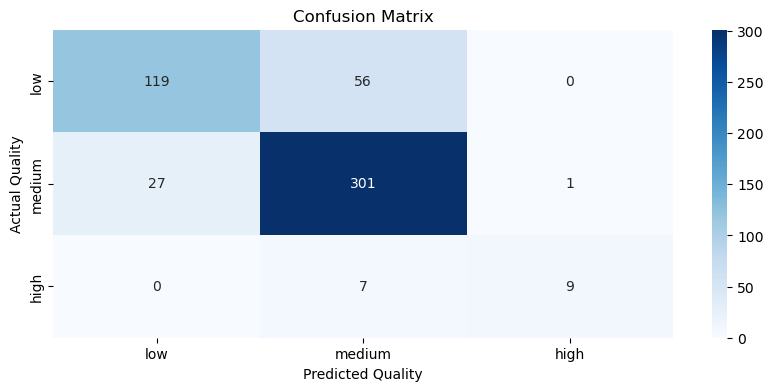

In [ ]:
cm = confusion_matrix(y_test_fold, rf_pred)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=["low","medium","high"], yticklabels=["low","medium","high"])
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Confusion Matrix')
plt.show()

# XGBOOST with stratifed kfold cross validation

In [124]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multiclass classification
    num_class=3,               # Number of classes (low, medium, high)
    eval_metric='mlogloss',    # Metric for multiclass
    random_state=42
)

scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X2)

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []
lst_kappa =[]
lst_balanced_accuracy_score =[]
  
for train_index, test_index in skf.split(X2,y2):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y2[train_index], y2[test_index]
    xgb_model.fit(x_train_fold, y_train_fold)
    xgb_pred = xgb_model.predict(x_test_fold) 
    kappa = cohen_kappa_score(xgb_pred, y_test_fold)
    lst_accu_stratified.append(xgb_model.score(x_test_fold, y_test_fold))
    balanced_acc_sc = balanced_accuracy_score(y_test_fold, xgb_pred)
    lst_balanced_accuracy_score.append(f"{balanced_acc_sc:.4f}")
    lst_kappa.append(f"{kappa:.4f}")


  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))
print("\nList of possible Cohen-Kappa score:", lst_kappa)
print("\nList of possible balanced accuracy score:", lst_balanced_accuracy_score)

List of possible accuracy: [0.8291746641074856, 0.8042226487523992, 0.7869481765834933, 0.8042226487523992, 0.817658349328215, 0.800383877159309, 0.8080614203454894, 0.7907869481765835, 0.8157389635316699, 0.8096153846153846]

Maximum Accuracy That can be obtained from this model is: 82.91746641074856 %

Minimum Accuracy: 78.69481765834932 %

Overall Accuracy: 80.66813081352429 %

Standard Deviation is: 0.012528970606750161

List of possible Cohen-Kappa score: ['0.6384', '0.5752', '0.5473', '0.5789', '0.6014', '0.5743', '0.5947', '0.5529', '0.6082', '0.5910']

List of possible balanced accuracy score: ['0.7311', '0.6099', '0.6413', '0.5945', '0.6548', '0.6322', '0.6522', '0.6231', '0.6993', '0.7101']


## Confusion matrix XGBoost ( without kfold)

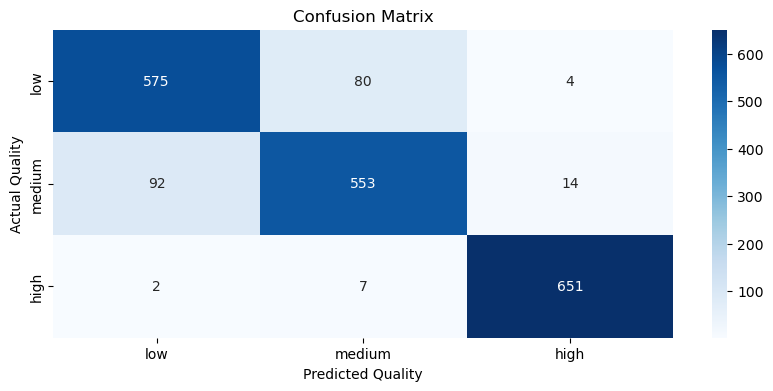

In [ ]:
#!SECTION check for the variables! they are repeated
cm = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=["low","medium","high"], yticklabels=["low","medium","high"])
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Confusion Matrix')
plt.show()

confusion matrix xgboost with fold

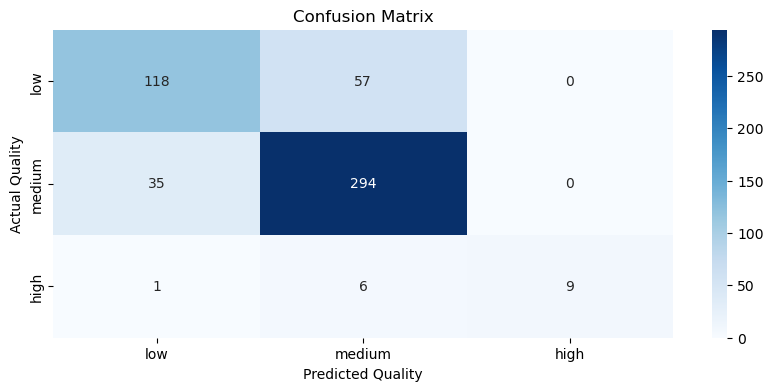

In [125]:
cm = confusion_matrix(y_test_fold, xgb_pred)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=["low","medium","high"], yticklabels=["low","medium","high"])
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Confusion Matrix')
plt.show()

# Result comparison

In [ ]:
# # Classification report
print("Classification Report: Random forest with Stratified K-fold cross validation")
print(classification_report(y_test_fold, rf_pred))
# Confusion matrix
print("Classification Report: XGBoost")
print(classification_report(y_test, xgb_pred))

Classification Report: Random forest with Stratified K-fold cross validation
              precision    recall  f1-score   support

         0.0       0.82      0.68      0.74       175
         1.0       0.83      0.91      0.87       329
         2.0       0.90      0.56      0.69        16

    accuracy                           0.82       520
   macro avg       0.85      0.72      0.77       520
weighted avg       0.83      0.82      0.82       520

Classification Report: XGBoost
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87       659
         1.0       0.86      0.84      0.85       659
         2.0       0.97      0.99      0.98       660

    accuracy                           0.90      1978
   macro avg       0.90      0.90      0.90      1978
weighted avg       0.90      0.90      0.90      1978



In [ ]:
y_test_fold.value_counts()

quality_label_encoded
1.0    329
0.0    175
2.0     16
Name: count, dtype: int64

In [ ]:
white_and_red_filtered["quality_label"].value_counts()

quality_label
medium    3296
low       1752
high       161
Name: count, dtype: int64

## Model 5- Random forest with Stratified K-fold cross validation and SMOTE

In [ ]:
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X2)
# Create  classifier object.
# lr = linear_model.LogisticRegression()
rf = RandomForestClassifier(class_weight="balanced")
  
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []
  
for train_index, test_index in skf.split(X2,y2):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y2[train_index], y2[test_index]
    pipe.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(pipe.score(x_test_fold, y_test_fold))
  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [0.8310940499040307, 0.7927063339731286, 0.7869481765834933, 0.8119001919385797, 0.8195777351247601, 0.8157389635316699, 0.7888675623800384, 0.7984644913627639, 0.8195777351247601, 0.7903846153846154]

Maximum Accuracy That can be obtained from this model is: 83.10940499040306 %

Minimum Accuracy: 78.69481765834932 %

Overall Accuracy: 80.5525985530784 %

Standard Deviation is: 0.015845335728265974


# Balancing the dataset

#REVIEW - should i filter outliers after the split, but only on the training set? 
https://towardsdatascience.com/preventing-data-leakage-in-your-machine-learning-model-9ae54b3cd1fb
'After splitting, do not perform exploratory data analysis on the validation and test sets — only the train set! Any additional features or model updates generated by insights from examining the validation or test sets are instances of data leakage'